In [1]:
import pyrootutils
root = pyrootutils.setup_root(".", pythonpath=True, cwd=True)

In [2]:
import pandas as pd
import numpy as np
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import os
from tqdm import tqdm
import rich
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
# from src.data.face_age_dataset import FaceAgeDataset
from src.data.face_age_dataset_from_path import FaceAgeDataset

In [4]:
class cfg:
    img_size = (224, 224)
    max_age = 80
    val_size = 1600
    test_size = 1600
    max_imgs_per_class = 500
    oversample_with_augmentation = True

In [5]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
transform = [transforms.Normalize(imagenet_mean, imagenet_std)]

ds = FaceAgeDataset(
    data_dir="data/",
    img_size=cfg.img_size,
    label_clipping=(1, cfg.max_age),
    normalize_labels=False,
    transform=transform,
)

In [6]:
x, y, idx = ds[0]
x.shape, y.shape, idx

(torch.Size([3, 224, 224]), torch.Size([1]), 0)

In [7]:
# create folders for new dataset
os.makedirs("data/face_age_dataset/train", exist_ok=True)
os.makedirs("data/face_age_dataset/val", exist_ok=True)
os.makedirs("data/face_age_dataset/test", exist_ok=True)

In [8]:
imgs_per_val_class = int(cfg.val_size / cfg.max_age)
imgs_per_test_class = int(cfg.test_size / cfg.max_age)

used_idxs = set() # img ids used for validation and testing

### Generate validation set

In [9]:
class_counts_val = Counter()

for x, y, idx in tqdm(DataLoader(ds, shuffle=True)):
    idx = int(idx)
    y = int(y)
    count = class_counts_val[y]
    
    if count < imgs_per_val_class and idx not in used_idxs:
        class_counts_val[y] += 1
        used_idxs.add(idx)
        x = x.squeeze(0)
        torch.save(x, f"data/face_age_dataset/val/{idx}_age_{y}.pt")
        
print("Val imgs:", sum(class_counts_val.values()))

100%|██████████| 23708/23708 [00:39<00:00, 594.71it/s]

Val imgs: 1600


### Generate test set

In [10]:
class_counts_test = Counter()

for x, y, idx in tqdm(DataLoader(ds, shuffle=True)):
    idx = int(idx)
    y = int(y)
    count = class_counts_test[y]
    
    if count < imgs_per_test_class and idx not in used_idxs:
        class_counts_test[y] += 1
        used_idxs.add(idx)
        x = x.squeeze(0)
        torch.save(x, f"data/face_age_dataset/test/{idx}_age_{y}.pt")
        
print("Test imgs:", sum(class_counts_test.values()))

100%|██████████| 23708/23708 [00:34<00:00, 691.39it/s]

Test imgs: 1556


### Generate train set

In [11]:
class_counts_train = Counter()

for x, y, idx in tqdm(DataLoader(ds, shuffle=True)):
    idx = int(idx)
    y = int(y)
    count = class_counts_train[y]
    
    if count < cfg.max_imgs_per_class and idx not in used_idxs:
        class_counts_train[y] += 1
        x = x.squeeze(0)
        torch.save(x, f"data/face_age_dataset/train/{idx}_age_{y}.pt")

print("Train imgs:", sum(class_counts_train.values()))

100%|██████████| 23708/23708 [01:41<00:00, 234.08it/s]

Train imgs: 16535


### Augment train set

Before augmentation:


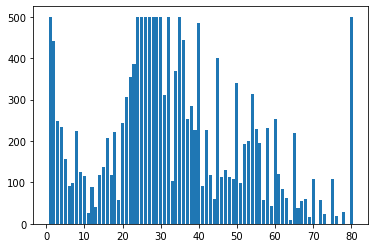

100%|██████████| 80/80 [05:53<00:00,  4.41s/it]

After augmentation:


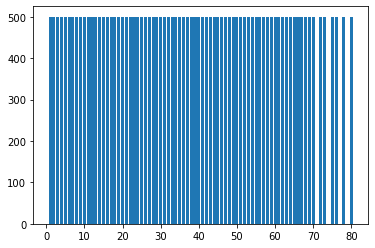

In [12]:
print("Before augmentation:")
plt.bar(class_counts_train.keys(), class_counts_train.values())
plt.show()

transform_list = [
    transforms.RandomRotation(20),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
]
transform = transforms.Compose(transform_list)

if cfg.oversample_with_augmentation:
    os.makedirs("data/face_age_dataset/train_augmented", exist_ok=True)
    augmented_imgs_count = 0
    
    # iterate over labels
    for label in tqdm(range(1, cfg.max_age + 1)):
        
        # load all images for label
        img_paths = [x for x in os.listdir("data/face_age_dataset/train") if f"age_{label}.pt" in x]
        imgs = [torch.load(f"data/face_age_dataset/train/{x}") for x in img_paths]
        
        if not imgs:
            continue
        
        # augment images while there are less than max_imgs_per_class
        augmented_imgs = []
        while len(imgs) + len(augmented_imgs) < cfg.max_imgs_per_class:
            for img in imgs:
                
                if len(imgs) + len(augmented_imgs) >= cfg.max_imgs_per_class:
                    break
                
                augmented_imgs_count += 1
                class_counts_train[label] += 1
                augmented_imgs.append(transform(img))
                
        for idx, img in enumerate(augmented_imgs):
            torch.save(img, f"data/face_age_dataset/train_augmented/augmented_{idx}_age_{label}.pt")
        
print("After augmentation:")
plt.bar(class_counts_train.keys(), class_counts_train.values())
plt.show()

In [13]:
print("Train", class_counts_train)
print("Val", class_counts_val)
print("Test", class_counts_test)

print(len(class_counts_train.keys()))
print(len(class_counts_val.keys()))
print(len(class_counts_test.keys()))

print("Train imgs:", sum(class_counts_train.values()))
print("Val imgs:", sum(class_counts_val.values()))
print("Test imgs:", sum(class_counts_test.values()))

Train Counter({70: 500, 34: 500, 52: 500, 3: 500, 22: 500, 31: 500, 29: 500, 35: 500, 37: 500, 21: 500, 59: 500, 6: 500, 4: 500, 2: 500, 26: 500, 17: 500, 72: 500, 24: 500, 1: 500, 32: 500, 12: 500, 28: 500, 7: 500, 43: 500, 5: 500, 27: 500, 38: 500, 30: 500, 25: 500, 45: 500, 49: 500, 42: 500, 23: 500, 18: 500, 16: 500, 39: 500, 8: 500, 19: 500, 53: 500, 15: 500, 36: 500, 10: 500, 9: 500, 50: 500, 40: 500, 58: 500, 61: 500, 54: 500, 65: 500, 80: 500, 46: 500, 51: 500, 47: 500, 60: 500, 55: 500, 63: 500, 20: 500, 14: 500, 44: 500, 56: 500, 75: 500, 78: 500, 66: 500, 41: 500, 48: 500, 62: 500, 73: 500, 33: 500, 57: 500, 76: 500, 68: 500, 67: 500, 13: 500, 64: 500, 11: 500, 69: 500})
Val Counter({60: 20, 42: 20, 35: 20, 22: 20, 23: 20, 26: 20, 28: 20, 1: 20, 17: 20, 6: 20, 80: 20, 10: 20, 30: 20, 24: 20, 36: 20, 18: 20, 37: 20, 41: 20, 14: 20, 53: 20, 54: 20, 3: 20, 46: 20, 20: 20, 38: 20, 58: 20, 31: 20, 67: 20, 72: 20, 2: 20, 34: 20, 9: 20, 8: 20, 63: 20, 73: 20, 4: 20, 32: 20, 55: 20,